In [1]:
# Transfer Learning using Resnet18
# 2 class classifer OK and NG1
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time, os
import copy
import random
from PIL import Image

# same implementation
seed = 1192 # Let's make a good country, Kamakura!
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed_all(seed)

print(device)
batch_size = 4

cpu


In [2]:
import torchvision.models as models
import torch.nn.functional as F

class AttentionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        base_model = models.resnet34(pretrained=True)
        self.features = nn.Sequential(*[layer for layer in base_model.children()][:-2])
        self.attn_conv = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.Sigmoid()
        )
            
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )
            
        self.mask_ = None
        
    def forward(self, x):
            
        x = self.features(x)

        attn = self.attn_conv(x) # [B, 1, H, W]
        B, _, H, W = attn.shape
        self.mask_ = attn.detach().cpu()

        x = x * attn
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.reshape(B, -1)

        return self.fc(x)
        
    def save_attention_mask(self, x, path):
        B = x.shape[0]
        self.forward(x)
        x = x.cpu() * torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1)
        x = x + torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
        fig, axs = plt.subplots(4, 2, figsize=(6, 8))

        plt.axis('off')
        for i in range(4):
            axs[i, 0].imshow(x[i].permute(1, 2, 0))
            axs[i, 1].imshow(self.mask_[i][0])
        plt.savefig(path)
        plt.close()

In [3]:
model_ft = AttentionNetwork()
model_ft = model_ft.to(device)
# print(model_ft)
criterion = nn.BCELoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [4]:
class originalCrop(object):

    def __init__(self, left_up, right_down):
        self._left_up = left_up
        self._right_down = right_down

    def __call__(self, img):
        image = img.crop((self._left_up[0], self._left_up[1], self._right_down[0], self._right_down[1]))
        return image

In [5]:
data_transforms = {
    'train': transforms.Compose([
    # transforms.RandomResizedCrop(224),
    # transforms.CenterCrop((300,400) ),
#     originalCrop((50,140),(550,750)), # leftup, rightdown
    # transforms.functional.resized_crop(top=200,left=0,width=600,height=600,size=(224,224)), # top, left, width, height

    transforms.Resize( (224,224) ),
    transforms.RandomRotation(degrees=(-180,180) ),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
    # transforms.CenterCrop((300,400) ),
    # transforms.functional.resized_crop(200,0,600,600,size=(224,224)), # top, left, width, height
#     originalCrop((50,140),(550,750)),## leftup, rightdown
    transforms.Resize( (224,224) ),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
train_dir = "/Users/seiji/data/experiment_metal_nut/train/"
val_dir = "/Users/seiji/data/experiment_metal_nut/val/"

# train : test = 8:2
# full_datasets = datasets.ImageFolder( root= train_dir , transform = data_transforms['train'])
# train_size = int(0.8 * len(full_datasets)); val_size = len(full_datasets) - train_size
# train_datasets, val_datasets = torch.utils.data.random_split(full_datasets, [train_size, val_size])

train_datasets = datasets.ImageFolder( root= train_dir , transform = data_transforms['train'])
val_datasets = datasets.ImageFolder( root= val_dir , transform = data_transforms['test'])

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size,shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True, num_workers=4)

print(len(train_loader.dataset))
print(len(val_loader.dataset)) # ファイル数はバッチサイズ×バッチ数-数枚(保留)

276
59


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


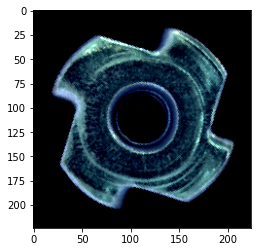

tensor(0)


In [7]:
check_loader = torch.utils.data.DataLoader(train_datasets, batch_size=1,shuffle=True, num_workers=4)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# 訓練データをランダムに取得
dataiter = iter(check_loader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % labels[labels[j]] for j in range(1)))

In [8]:
from torch.autograd import Variable
import copy

train_loss,train_acc = [],[]
val_loss, val_acc = [],[]
preds = []

t = Variable(torch.Tensor([0.5]))
t = t.to(device)

_epoch = 15
min_loss = 10000.0 # terrible operation

for epoch in range(_epoch):

################################# training #########################################

    model_ft.train() # 学習モード
    run_train_loss = 0.0; run_train_acc = 0.0
    for data, target in train_loader:

        # Variable → Cuda
        data, target = Variable(data), Variable(target.float()) # 微分可能に変換
        data = data.to(device); target = target.to(device)
        optimizer_ft.zero_grad() # 一度計算された勾配結果を0にリセット

        # Output
        output = model_ft(data) # 入力dataをinputし、出力を求める
        output = torch.nn.Sigmoid()(output)
        # _, preds = torch.max(output, 1)
        # Calculate Loss and Backprop
        loss = criterion(output[:,0],target.float())


        preds = (output > t).float() * 1

        loss.backward() # 誤差のバックプロパゲーションを求める
        optimizer_ft.step() # バックプロパゲーションの値で重みを更新する
        
        # Sum of Loss
        run_train_loss += loss.item()
        # run_train_acc += torch.sum(preds == target.data.float())
        run_train_acc += preds.eq(target.float().data.view_as(preds)).sum() # 正解と一緒だったらカウントアップ

    run_train_loss = run_train_loss / len(train_loader.dataset)
    run_train_acc = 100. * run_train_acc / len(train_loader.dataset)
        
    print('====> Epoch: {} train loss: {:.4f} train acc: {:.4f}'.format(epoch, run_train_loss, run_train_acc))
    train_loss.append(run_train_loss); train_acc.append(run_train_acc)


################################ validation #######################################


    model_ft.eval() # ネットワークを推論モードに切り替える
    correct = 0
    run_val_loss = 0.0; run_val_acc = 0.0
    for data, target in val_loader:
        data = data.to(device); target = target.to(device) #data, target = Variable(data), Variable(target) # 微分可能に変換

        output = model_ft(data) # 入力dataをinputし、出力を求める
        output = torch.nn.Sigmoid()(output)
        # pred = output.data.max(1, keepdim=True)[1] # 出力ラベルを求める
        # loss = criterion(output,target.float())
        # loss = sigmoid_binary_cross_entropy(output,target.float())
        loss = criterion(output[:,0],target.float())

        # loss = binary_cross_entropy(output,target.float())

        preds = (output > t).float() * 1

        run_val_loss += loss.item()
        run_val_acc += preds.eq(target.float().data.view_as(preds)).sum() # 正解と一緒だったらカウントアップ


    run_val_loss = run_val_loss / len(val_loader.dataset)
    run_val_acc = 100. * run_val_acc / len(val_loader.dataset)

    # best_model_save
    if run_val_loss < min_loss:
        min_loss = run_val_loss
        save_model = copy.deepcopy(model_ft)
        print("update best model!")

    print('====> Epoch: {} Val loss: {:.4f} Val acc: {:.4f}'.format(epoch, run_val_loss, run_val_acc))
    val_loss.append(run_val_loss); val_acc.append(run_val_acc)

====> Epoch: 0 train loss: 0.1375 train acc: 78.9855
update best model!
====> Epoch: 0 Val loss: 0.2497 Val acc: 37.2881
====> Epoch: 1 train loss: 0.1201 train acc: 79.7101
update best model!
====> Epoch: 1 Val loss: 0.2460 Val acc: 37.2881
====> Epoch: 2 train loss: 0.1167 train acc: 79.7101
update best model!
====> Epoch: 2 Val loss: 0.2454 Val acc: 37.2881
====> Epoch: 3 train loss: 0.1086 train acc: 79.7101
update best model!
====> Epoch: 3 Val loss: 0.2156 Val acc: 37.2881
====> Epoch: 4 train loss: 0.1133 train acc: 79.7101
====> Epoch: 4 Val loss: 0.2195 Val acc: 37.2881
====> Epoch: 5 train loss: 0.1051 train acc: 79.7101
update best model!
====> Epoch: 5 Val loss: 0.2051 Val acc: 37.2881
====> Epoch: 6 train loss: 0.0954 train acc: 79.7101
update best model!
====> Epoch: 6 Val loss: 0.1984 Val acc: 37.2881
====> Epoch: 7 train loss: 0.0947 train acc: 80.0725
====> Epoch: 7 Val loss: 0.2116 Val acc: 37.2881
====> Epoch: 8 train loss: 0.0852 train acc: 79.7101
update best model

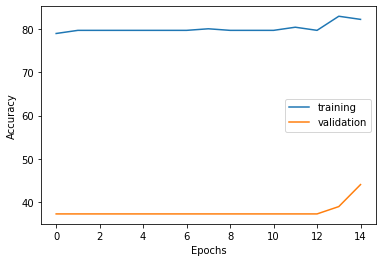

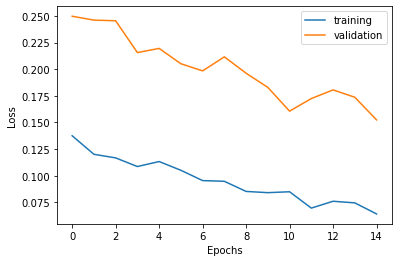

In [9]:
plt.plot(range(0, _epoch), train_acc, label="training")
plt.plot(range(0, _epoch), val_acc, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(range(0, _epoch), train_loss, label="training")
plt.plot(range(0, _epoch), val_loss, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
test_dir = "/Users/seiji/data/experiment_metal_nut/val/"
test_datasets = datasets.ImageFolder( root= test_dir , transform = data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=1 ,shuffle=False, num_workers=1)

# model_ft.eval() # ネットワークを推論モードに切り替える
correct = 0
test_loss = 0.0; test_acc = 0.0

t = Variable(torch.Tensor([0.4]))
t = t.to(device)

y_test = []
y_pred = []

out_ng = []
out_ok = []
preds = []

for data, target in test_loader:
    data = data.to(device); target = target.to(device) #data, target = Variable(data), Variable(target) # 微分可能に変換

    output = model_ft(data) # 入力dataをinputし、出力を求める
    output = torch.nn.Sigmoid()(output)
    

    preds = (output > t).float() * 1
    # pred = output.data.max(1, keepdim=True)[1] # 出力ラベルを求める

    loss = criterion(output,target.float())

    if target.item() == 0:
        out_ok.append(output.cpu().detach().numpy() )
    elif target.item() == 1:
        out_ng.append(output.cpu().detach().numpy() )

    y_pred.append(output.item())
    y_test.append(target.item())

    test_loss += loss.item()
    test_acc += preds.eq(target.float().data.view_as(preds)).sum() # 正解と一緒だったらカウントアップ

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100. * test_acc / len(test_loader.dataset)


/Users/seiji/opt/anaconda3/envs/sk/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


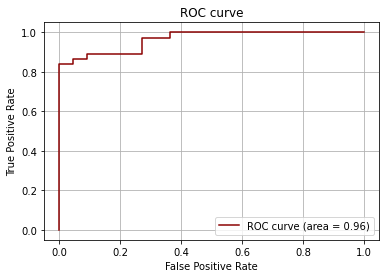

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc ,color="darkred")
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

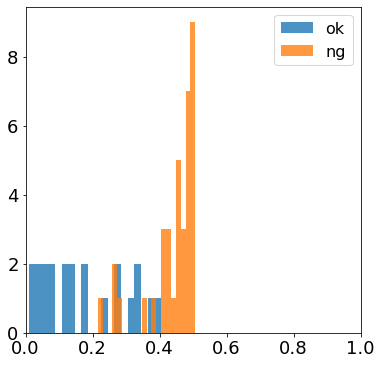

In [12]:
plt.figure(figsize=(6,6))
plt.rcParams["font.size"] = 18

# plt.hist([out_ok,out_ng],color=["#2064a0","#e81619"], bins=30, alpha=0.7 )

out_ok = np.array(out_ok).flatten()
out_ng = np.array(out_ng).flatten()

hist_weights_ok = np.ones_like(out_ok)/float(len(out_ok))
hist_weights_ng = np.ones_like(out_ng)/float(len(out_ng))

# plt.title('hist ok and ng', fontsize=16)


# plt.hist(out_ok, alpha=0.8, bins=50,weights=hist_weights_ok,label="ok")
# plt.hist(out_ng, alpha=0.8,bins=50,weights=hist_weights_ng,label="ng")
plt.hist(out_ok, alpha=0.8, bins=20,label="ok")
plt.hist(out_ng, alpha=0.8,bins=20,label="ng")

# xmin = 0; xmax = 30
# plt.vlines([th], xmin, xmax, "blue", linestyles='dashed',color='red')
# mean = np.mean(arr_mae_OK)
# std = np.std(arr_mae_OK)
# lower = np.min(arr_mae_OK)
# upper = np.max(arr_mae_NG)
# plt.ylim([1,2600])
plt.xlim([0,1])
# plt.xlim([lower,upper]); plt.ylim([0,30])

plt.legend(fontsize=16 ,loc='upper right')
# plt.show()
# plt.savefig("res_tokushima_train_and_test_with_resnet.png")

In [13]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
f1_scores = []

for thresh in thresholds:
    f1_scores.append(f1_score(y_test, [1 if m > thresh else 0 for m in y_pred]))
f1_scores = np.array(f1_scores)
max_f1 = f1_scores.max()
max_f1_threshold = thresholds[f1_scores.argmax()]

print(max_f1,max_f1_threshold)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("########################################################################")
print("--------------------------- th = min_ng -------------------------------")

th = np.min(out_ng)

bin_pred = [1 if p >= th else 0 for p in y_pred]
m = confusion_matrix(y_test, bin_pred,labels=[1,0])
print('Confution Matrix:\n{}'.format(m))

print("threshold:{:.3f}".format(th))
print("--------------------------------------------------------------------------")
print('Accuracy:{:.3f}'.format(accuracy_score(y_test, bin_pred)))
print('Recall:{:.3f}'.format(recall_score(y_test, bin_pred)))
print('Precision:{:.3f}'.format(precision_score(y_test, bin_pred)))
print('F1-measure:{:.3f}'.format(f1_score(y_test, bin_pred)))
print("--------------------------------------------------------------------------")
print("未検出率(FNR):{:.3f} (must be 0.0)".format( m[0,1]/(m[0,1] + m[0,0]) ) )
print("過検出率(FPR):{:.3f}".format(m[1,0]/(m[1,0] + m[1,1])))
print("変な未検出率:{:.3f} (になるようにThreshold決定)".format( m[0,1]/( np.sum(m) ) ) )
print("変な過検出率:{:.3f}".format(m[1,0]/(np.sum(m))))
print("--------------------------------------------------------------------------")
print("########################################################################")


print("--------------------------- th = f1_max -------------------------------")

th = max_f1_threshold
# th = 0.5

bin_pred = [1 if p >= th else 0 for p in y_pred]
m = confusion_matrix(y_test, bin_pred,labels=[1,0])
print('Confution Matrix:\n{}'.format(m))

print("threshold:{:.3f}".format(th))
print("--------------------------------------------------------------------------")
print('Accuracy:{:.3f}'.format(accuracy_score(y_test, bin_pred)))
print('Recall:{:.3f}'.format(recall_score(y_test, bin_pred)))
print('Precision:{:.3f}'.format(precision_score(y_test, bin_pred)))
print('F1-measure:{:.3f}'.format(f1_score(y_test, bin_pred)))
print("--------------------------------------------------------------------------")
print("未検出率(FNR):{:.3f} (must be 0.0)".format( m[0,1]/(m[0,1] + m[0,0]) ) )
print("過検出率(FPR):{:.3f}".format(m[1,0]/(m[1,0] + m[1,1])))
print("変な未検出率:{:.3f} (になるようにThreshold決定)".format( m[0,1]/( np.sum(m) ) ) )
print("変な過検出率:{:.3f}".format(m[1,0]/(np.sum(m))))
print("--------------------------------------------------------------------------")
print("########################################################################")

0.9142857142857143 0.3645692765712738
########################################################################
--------------------------- th = min_ng -------------------------------
Confution Matrix:
[[37  0]
 [ 8 14]]
threshold:0.215
--------------------------------------------------------------------------
Accuracy:0.864
Recall:1.000
Precision:0.822
F1-measure:0.902
--------------------------------------------------------------------------
未検出率(FNR):0.000 (must be 0.0)
過検出率(FPR):0.364
変な未検出率:0.000 (になるようにThreshold決定)
変な過検出率:0.136
--------------------------------------------------------------------------
########################################################################
--------------------------- th = f1_max -------------------------------
Confution Matrix:
[[32  5]
 [ 2 20]]
threshold:0.365
--------------------------------------------------------------------------
Accuracy:0.881
Recall:0.865
Precision:0.941
F1-measure:0.901
----------------------------------------------------

In [19]:
check_loader = torch.utils.data.DataLoader(val_datasets, batch_size=4 ,shuffle=True, num_workers=4)
dataiter = iter(check_loader)
images, labels = dataiter.next()

model_ft.save_attention_mask(images, "result.png")

In [15]:
# from torchvision import datasets

# class ImageFolderWithPaths(datasets.ImageFolder):
# """Custom dataset that includes image file paths. Extends
# torchvision.datasets.ImageFolder
# """

# # override the __getitem__ method. this is the method that dataloader calls
# def __getitem__(self, index):
# # this is what ImageFolder normally returns
# original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
# # the image file path
# path = self.imgs[index][0]
# # make a new tuple that includes original and the path
# tuple_with_path = (original_tuple + (path,))
# return tuple_with_path

# import glob
# from PIL import Image

# ok2ng_list = []
# out_ok=[]

# print("------------- test ok samples --------------")
# cnt = 0
# # test ok sample
# path_test = "./data/val/0_ok/*.jpg"

# img_paths = glob.glob( path_test )
# for path in img_paths:
# org_img = Image.open(path)
# test_img = org_img.convert('RGB')
# test_img = data_transforms['test'](test_img)
# test_img = test_img.unsqueeze(0)
# test_img = test_img.to(device)

# output = model_ft(test_img)
# output = torch.nn.Sigmoid()(output)

# out_ok.append(output.item())

# # print(.shape)
# if 0.8 < output.item():
# plt.imsave("./res/ok2ng/" + path.split("/")[-1] , np.array(org_img))
# ok2ng_list.append(path.split("/")[-1])
# cnt = cnt + 1

# print(ok2ng_list)

# # np.savetxt("./res/ok2ng_list.txt",np.array(ok2ng_list),fmt='%s' )
# print( str(cnt) + " / " + str( len(img_paths) ) + "枚ミスった" )

# ng2ok_list = []
# out_ng = []

# print("------------- test ng samples --------------")
# cnt = 0
# # test ok sample
# path_test = "./data/val/1_ng/*.jpg"

# img_paths = glob.glob( path_test )
# for path in img_paths:
# org_img = Image.open(path)
# test_img = org_img.convert('RGB')
# test_img = data_transforms['test'](test_img)
# test_img = test_img.unsqueeze(0)
# test_img = test_img.to(device)

# output = model_ft(test_img)
# output = torch.nn.Sigmoid()(output)

# out_ng.append(output.item())

# if output.item() < 0.1:
# plt.imsave("./res/ng2ok/" + path.split("/")[-1] , np.array(org_img))
# ng2ok_list.append(path.split("/")[-1])
# cnt = cnt + 1

# # np.savetxt("./res/ng2ok_list.txt",np.array(ng2ok_list),fmt='%s' )
# print( str(cnt) + " / " + str( len(img_paths) ) +"枚ミスった．")

# plt.figure(figsize=(6,6))

# out_ok = np.array(out_ok).flatten()
# out_ng = np.array(out_ng).flatten()
# hist_weights_ok = np.ones_like(out_ok) /float(len(out_ok))
# hist_weights_ng = np.ones_like(out_ng) /float(len(out_ng))

# # plt.hist(out_ok, alpha=0.8, bins=50,weights=hist_weights_ok,label="ok")
# # plt.hist(out_ng, alpha=0.8,bins=50,weights=hist_weights_ng,label="ng")

# plt.hist(out_ok, alpha=0.8, bins=50,label="ok")
# plt.hist(out_ng, alpha=0.8,bins=50,label="ng")

# plt.xlim(0, 1.0)
# plt.legend(fontsize=16 ,loc='upper left')
# plt.tick_params(labelsize=14)
# plt.show()